## 3.1 Data preparation 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('Telco-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender', 
    'seniorcitizen', 
    'partner', 
    'dependents',
    'phoneservice', 
    'multiplelines', 
    'internetservice',
    'onlinesecurity', 
    'onlinebackup', 
    'deviceprotection', 
    'techsupport',
    'streamingtv', 
    'streamingmovies', 
    'contract', 
    'paperlessbilling',
    'paymentmethod'
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\LENOVO\OneDrive\Desktop\ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
LogisticRegression()

LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

## 4.2 Accuracy and dummy model
 - Evaluate the model on different thresholds
 - Check the accuracy of dummy baselines

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

np.int64(1131)

In [11]:
1131 / 1409

0.8026969481902059

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

In [14]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.595
0.15 0.665
0.20 0.707
0.25 0.737
0.30 0.760
0.35 0.773
0.40 0.784
0.45 0.792
0.50 0.803
0.55 0.800
0.60 0.796
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


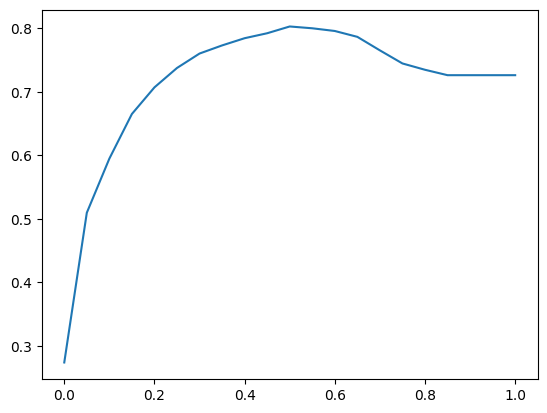

In [15]:
plt.plot(thresholds, scores)

In [16]:
from collections import Counter

In [17]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

## Confusion table
 - Different type of errors and correct decisions
 - Arranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
actual_negative

array([ True,  True,  True, ...,  True, False, False])

In [20]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [21]:
predict_negative

array([ True,  True,  True, ...,  True, False, False])

In [54]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

In [55]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [56]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[920, 103],
       [175, 211]])

In [57]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision Curves

In [58]:
(tp + tn) / (tp + tn + fp + fn)

np.float64(0.8026969481902059)

In [59]:
p = tp / (tp + fp)
p

np.float64(0.6719745222929936)

In [60]:
total_predicted_churn = tp + fp
actual_churn = tp
total_predicted_churn, actual_churn

(np.int64(314), np.int64(211))

In [61]:
r = tp / (tp + fn)
r

np.float64(0.5466321243523317)

In [75]:
tp + fn

np.int64(386)

## 4.5 ROC curves
 - TPR and FPR

In [76]:
tpr = tp / (tp + fn)
tpr

np.float64(0.0)

In [77]:
fpr = fp / (fp + tn)
fpr

np.float64(0.0)

In [87]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [104]:
columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [106]:
df_scores[::10]

,thresholds,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,551,20,472,0.948187,0.538612
20,0.2,333,360,53,663,0.862694,0.351906
30,0.3,285,237,101,786,0.738342,0.231672
40,0.4,249,167,137,856,0.645078,0.163245
50,0.5,211,103,175,920,0.546632,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,76,21,310,1002,0.196891,0.020528
80,0.8,14,2,372,1021,0.036269,0.001955
90,0.9,0,0,386,1023,0.000000,0.000000


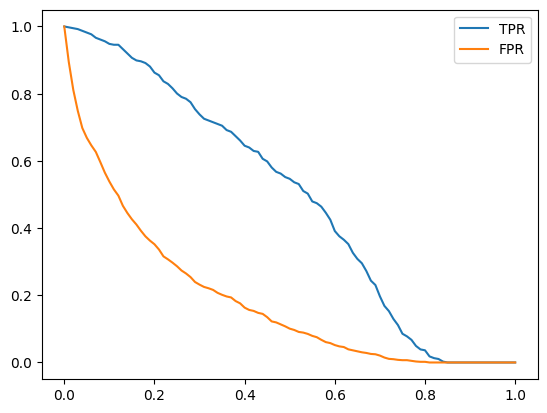

In [113]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label='TPR')
plt.plot(df_scores.thresholds, df_scores['fpr'], label='FPR')
plt.legend()

## Random model

In [117]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [121]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [122]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, fn, tn))

    columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [124]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

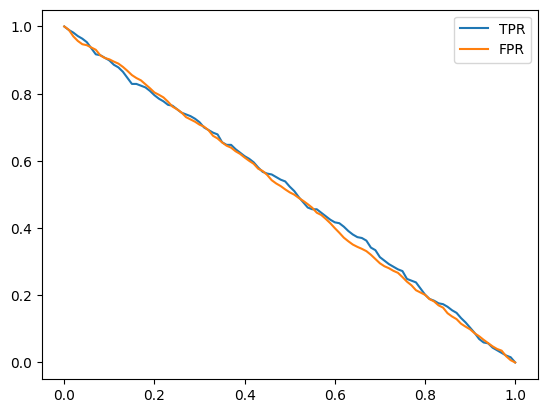

In [126]:
df_rand[::10]

plt.plot(df_rand.thresholds, df_rand['tpr'], label='TPR')
plt.plot(df_rand.thresholds, df_rand['fpr'], label='FPR')
plt.legend()

In [127]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

num_neg, num_pos

(np.int64(1023), np.int64(386))

In [129]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [130]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [131]:
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [140]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [139]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [142]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

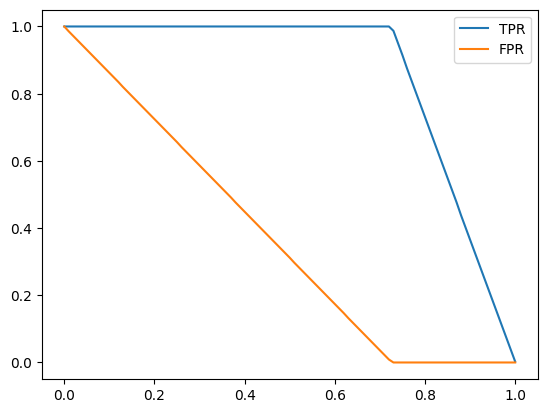

In [145]:
df_ideal[::10]

plt.plot(df_ideal.thresholds, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.thresholds, df_ideal['fpr'], label='FPR')
plt.legend()

## Putting everything togather

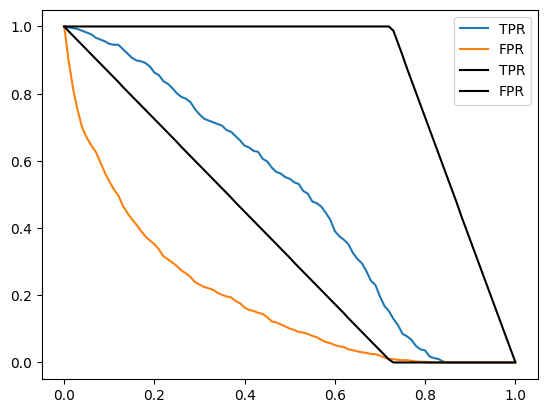

In [147]:
plt.plot(df_scores.thresholds, df_scores['tpr'], label='TPR')
plt.plot(df_scores.thresholds, df_scores['fpr'], label='FPR')

# plt.plot(df_rand.thresholds, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.thresholds, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.thresholds, df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.thresholds, df_ideal['fpr'], label='FPR', color='black')

plt.legend()

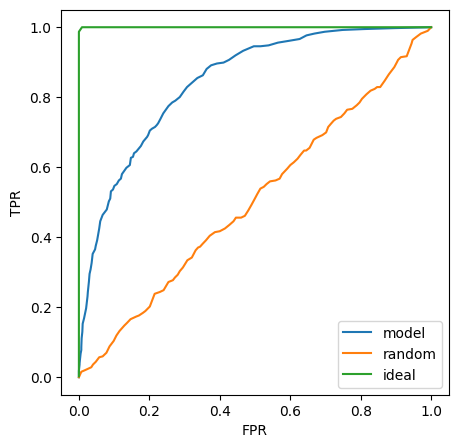

In [155]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1] label='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

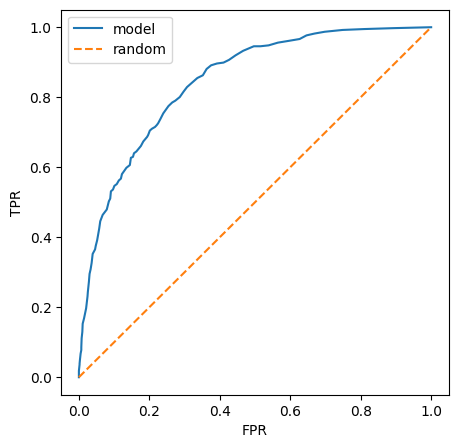

In [159]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [156]:
from sklearn.metrics import roc_curve

In [160]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

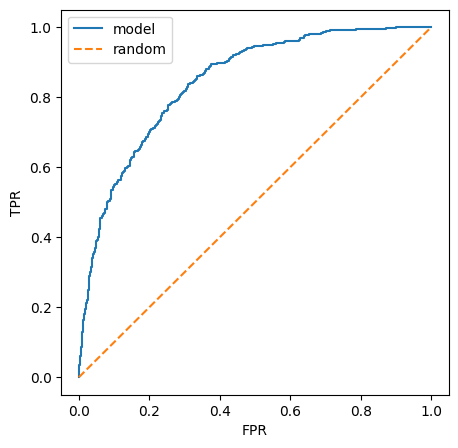

In [161]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='model')
plt.plot([0, 1], [0, 1], label='random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()